In [1]:
import os
import io
from typing import Tuple, List, Dict

import numpy
import sklearn as sklearn
import torch
import tqdm as tqdm
from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch.utils.data import Dataset

from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.datasets import ImageFolder
from IPython.display import display

from tqdm.notebook import tqdm

In [2]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

def peek(train_dl):
    # test it out by taking a peek
    for _ in range(4):
        img1b, lbl = next(iter(train_dl))
            # img1 = F.to_pil_image(train_set.__getitem__(5)[0])
            # print(img1, lbl)
        print(img1b.shape, lbl.shape)
        for i, img1 in enumerate(img1b):
            img1 = F.to_pil_image(img1b[i])
            # img1.show()
            print(f"label: {'flipped' if lbl[i] else 'normal'}")
            display(img1)

cpu


In [41]:
import importlib
from orientation_nn import OrientationImageFolder
import orientation_nn
importlib.reload(orientation_nn)

# %load_ext autoreload
# %autoreload 1
# %aimport orientation_nn


<module 'orientation_nn' from 'C:\\conjunct\\unline\\orientation\\orientation_nn.py'>

In [31]:
train_transform = transforms.Compose([
    # transforms.RandomCrop(224, padding=50),
    # transforms.RandomResizedCrop(112, scale=(0.08, 0.25)),
    transforms.Resize((32, 256)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation((180, 180)),
    # transforms.RandomInvert(p=1),
    # transforms.RandomInvert(p=1),
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomInvert(p=0),
    transforms.ToTensor()
])

dataset = OrientationImageFolder('../iamdataset/sentences-sample', transform=train_transform)
# loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
from torch.utils.data import DataLoader


# test/train split
# prepare the dataset
def prepare_data(path):
    # define standardization
    # trans = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
    # load dataset
    _datalen = len(dataset)
    _trainlen = int(_datalen * .8)
    train_set, test_set = torch.utils.data.random_split(dataset, [_trainlen, _datalen - _trainlen])

    # prepare data loaders
    train_dl = DataLoader(train_set, batch_size=4, shuffle=True)
    test_dl = DataLoader(test_set, batch_size=16, shuffle=False)
    return train_dl, test_dl
train_dl, test_dl = prepare_data(dataset)

torch.Size([4, 3, 32, 256]) torch.Size([4])
label: normal


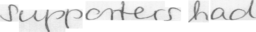

label: normal


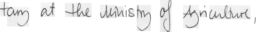

label: normal


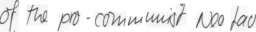

label: normal


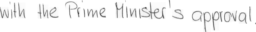

torch.Size([4, 3, 32, 256]) torch.Size([4])
label: flipped


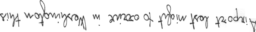

label: normal


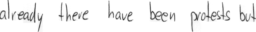

label: normal


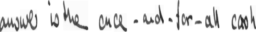

label: flipped


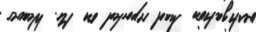

torch.Size([4, 3, 32, 256]) torch.Size([4])
label: flipped


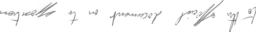

label: normal


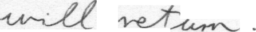

label: normal


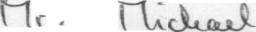

label: flipped


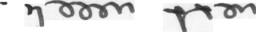

torch.Size([4, 3, 32, 256]) torch.Size([4])
label: normal


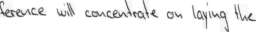

label: normal


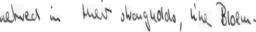

label: normal


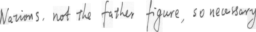

label: normal


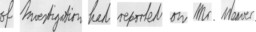

In [40]:
peek(train_dl)

In [34]:
# Goal: to use a CNN to determine the orientation of text: determine if it is upside down
from orientation_nn import OrientationCNN


# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters()) # , lr=0.01, momentum=0.9)
    # enumerate epochs
    # add progress bar

    for epoch in range(10):
        # enumerate mini batches
        for i, (inputs, targets) in tqdm(enumerate(train_dl)):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
        # save the model
        torch.save(model.state_dict(), f'model-v0.{epoch}.pt')

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = numpy.argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = numpy.vstack(predictions), numpy.vstack(actuals)
    # calculate accuracy
    acc = sklearn.metrics.accuracy_score(actuals, predictions)
    return acc

In [35]:
# prepare the data
# path = '~/.torch/datasets/mnist'
train_dl, test_dl = prepare_data('')
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = OrientationCNN()
# # train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

3585 897


0it [00:00, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x65536 and 16384x128)

In [42]:
print(model)
# get shape of tensor of dataset
print(dataset[0][0].shape)

from torchsummary import summary

# train_dl has torch.Size([4, 3, 32, 256]) with batch_size = 4
summary(model, (3, 32, 256))

OrientationCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
torch.Size([3, 32, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 32, 256]             896
            Conv2d-2          [-1, 64, 16, 128]          18,496
            Conv2d-3           [-1, 128, 8, 64]          73,856
            Linear-4                  [-1, 128]       2,097,280
           Dropout-5                  [-1, 128]               0
            Linear-6                    [-1, 2]             258
           Dropout-7                    [-1, 2

In [19]:
# load model from .pt file
# model = OrientationCNN()
# model.load_state_dict(torch.load('model_scripted.pt'))
# model.eval()
model = torch.jit.load('model_scripted.pt')

In [66]:
from sklearn.metrics import accuracy_score
from numpy import vstack


# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        actual = actual.reshape((len(actual), 1))
        # round to class values
        yhat = yhat.round()
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [13]:
evaluate_model(test_dl, model)

ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets